
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, nextQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, next_states, nextQs, # model data
               state_size, action_size, hidden_size): # model init
    # Calculating Qt
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states, 
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    # Calculating Qt+1
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, nextnext_states_logits = generator(prev_actions=actions_onehot, states=next_states,
                                                            hidden_size=hidden_size, state_size=state_size, 
                                                            action_size=action_size, reuse=True)
    # Masking actions_logits unmasked to create Qs
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # nextQs is targetQs/labels
    nextQs = tf.reshape(nextQs, [-1, 1])
    Qs = tf.reshape(Qs, [-1, 1])

    # Discriminator for nextQs_real and nextQs_fake
    # ~Qt
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                hidden_size=hidden_size)
    # ~Qt+1
    nextQs_real = discriminator(prev_actions=next_actions_logits, states=nextnext_states_logits, 
                                hidden_size=hidden_size, reuse=True)

    # Generator loss
    #g_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    #     g_loss_fake1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, #Qt vs Qt+1
    #                                                                           labels=tf.nn.sigmoid(nextQs)))
    g_loss_fake1 = tf.reduce_mean(tf.square(Qs - nextQs))
    #     g_loss_fake2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake,#~Qt vs Qt+1 
    #                                                                           labels=tf.nn.sigmoid(nextQs)))
    g_loss_fake2 = tf.reduce_mean(tf.square(nextQs_fake - nextQs))
    #     g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, #~Qt+1 vs 0
    #                                                                          labels=tf.zeros_like(nextQs)))
    #g_loss_real = tf.reduce_mean(tf.square(nextQs_real - tf.zeros_like(nextQs)))
    g_loss = g_loss_fake1 + g_loss_fake2 # + g_loss_real

    # Discriminator loss
    #     d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, #~Qt vs 0
    #                                                                          labels=tf.zeros_like(nextQs)))
    d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - tf.zeros_like(nextQs)))
    #     d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, #~Qt+1 vs Qt+1
    #                                                                          labels=tf.nn.sigmoid(nextQs)))
    d_loss_real = tf.reduce_mean(tf.square(nextQs_real - nextQs))
    d_loss = d_loss_fake + d_loss_real

    return actions_logits, g_loss, d_loss

In [10]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.nextQs = model_input(
            state_size=state_size)

        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            prev_actions=self.prev_actions, states=self.states, 
            actions=self.actions, next_states=self.next_states,
            nextQs=self.nextQs) # model input data
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss,
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [14]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 2000              # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.nextQs: nextQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 32 Training g_loss: 0.6398 Training d_loss: 0.2501 Explore P: 0.9968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 49 Training g_loss: 195.5388 Training d_loss: 77.4520 Explore P: 0.9920
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 14 Training g_loss: 611.1066 Training d_loss: 241.3676 Explore P: 0.9906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 20 Training g_loss: 1191.3408 Training d_loss: 469.2389 Explore P: 0.9887
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 33 Training g_loss: 0.0220 Training d_loss: 0.0142 Explore P: 0.9207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 14 Training g_loss: 0.0201 Training d_loss: 0.0131 Explore P: 0.9194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 12 Training g_loss: 0.0193 Training d_loss: 0.0124 Explore P: 0.9183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 25 Training g_loss: 0.0195 Training d_loss: 0.0126 Explore P: 0.9161
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 12 Training g_loss: 0.0339 Training d_loss: 0.0149 Explore P: 0.8657
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 15 Training g_loss: 0.0184 Training d_loss: 0.0098 Explore P: 0.8644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 9 Training g_loss: 0.0144 Training d_loss: 0.0084 Explore P: 0.8636
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 40 Training g_loss: 0.0154 Training d_loss: 0.0088 Explore P: 0.8602
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 11 Training g_loss: 0.0115 Training d_loss: 0.0068 Explore P: 0.8030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 11 Training g_loss: 0.0121 Training d_loss: 0.0070 Explore P: 0.8021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 47 Training g_loss: 0.0173 Training d_loss: 0.0114 Explore P: 0.7984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 20 Training g_loss: 0.4770 Training d_loss: 0.7622 Explore P: 0.7968
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 133 Total reward: 42 Training g_loss: 0.0096 Training d_loss: 0.0062 Explore P: 0.7492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 12 Training g_loss: 0.0119 Training d_loss: 0.0147 Explore P: 0.7483
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 17 Training g_loss: 0.3950 Training d_loss: 0.6114 Explore P: 0.7471
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 14 Training g_loss: 0.5039 Training d_loss: 0.7644 Explore P: 0.7461
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 13 Training g_loss: 0.0109 Training d_loss: 0.0072 Explore P: 0.7088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 9 Training g_loss: 0.0441 Training d_loss: 0.0717 Explore P: 0.7081
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 30 Training g_loss: 0.0104 Training d_loss: 0.0057 Explore P: 0.7060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 13 Training g_loss: 0.0099 Training d_loss: 0.0055 Explore P: 0.7051
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 200 Total reward: 16 Training g_loss: 0.0700 Training d_loss: 0.1309 Explore P: 0.6718
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 14 Training g_loss: 0.0203 Training d_loss: 0.0202 Explore P: 0.6709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 13 Training g_loss: 0.0144 Training d_loss: 0.0089 Explore P: 0.6700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 13 Training g_loss: 0.0069 Training d_loss: 0.0048 Explore P: 0.6692
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 233 Total reward: 13 Training g_loss: 0.0074 Training d_loss: 0.0038 Explore P: 0.6318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 15 Training g_loss: 0.0090 Training d_loss: 0.0049 Explore P: 0.6309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 12 Training g_loss: 0.0081 Training d_loss: 0.0045 Explore P: 0.6301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 8 Training g_loss: 0.0087 Training d_loss: 0.0060 Explore P: 0.6296
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 266 Total reward: 11 Training g_loss: 0.0144 Training d_loss: 0.0072 Explore P: 0.6024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 11 Training g_loss: 0.0135 Training d_loss: 0.0092 Explore P: 0.6018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 9 Training g_loss: 0.0375 Training d_loss: 0.0341 Explore P: 0.6012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 11 Training g_loss: 0.0876 Training d_loss: 0.1576 Explore P: 0.6006
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 300 Total reward: 10 Training g_loss: 0.0055 Training d_loss: 0.0051 Explore P: 0.5743
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 18 Training g_loss: 0.0457 Training d_loss: 0.0820 Explore P: 0.5733
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 15 Training g_loss: 0.0058 Training d_loss: 0.0032 Explore P: 0.5725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 16 Training g_loss: 0.0053 Training d_loss: 0.0029 Explore P: 0.5716
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 333 Total reward: 17 Training g_loss: 0.0049 Training d_loss: 0.0074 Explore P: 0.5478
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 15 Training g_loss: 0.0032 Training d_loss: 0.0019 Explore P: 0.5470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 10 Training g_loss: 0.0033 Training d_loss: 0.0021 Explore P: 0.5465
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 12 Training g_loss: 0.0044 Training d_loss: 0.0065 Explore P: 0.5458
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 367 Total reward: 11 Training g_loss: 0.0048 Training d_loss: 0.0061 Explore P: 0.5206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 11 Training g_loss: 0.0040 Training d_loss: 0.0029 Explore P: 0.5200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 29 Training g_loss: 0.0040 Training d_loss: 0.0034 Explore P: 0.5185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 18 Training g_loss: 0.0128 Training d_loss: 0.0253 Explore P: 0.5176
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 400 Total reward: 37 Training g_loss: 0.1080 Training d_loss: 0.0998 Explore P: 0.4959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 12 Training g_loss: 0.1755 Training d_loss: 0.2518 Explore P: 0.4953
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 17 Training g_loss: 0.0027 Training d_loss: 0.0024 Explore P: 0.4945
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 15 Training g_loss: 0.0451 Training d_loss: 0.1002 Explore P: 0.4938
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 433 Total reward: 13 Training g_loss: 0.0078 Training d_loss: 0.0073 Explore P: 0.4715
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 434 Total reward: 12 Training g_loss: 0.0061 Training d_loss: 0.0056 Explore P: 0.4709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 10 Training g_loss: 0.0102 Training d_loss: 0.0071 Explore P: 0.4705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 13 Training g_loss: 0.0098 Training d_loss: 0.0064 Explore P: 0.4699
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 466 Total reward: 14 Training g_loss: 0.0038 Training d_loss: 0.0030 Explore P: 0.4507
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 467 Total reward: 14 Training g_loss: 0.0034 Training d_loss: 0.0028 Explore P: 0.4501
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 12 Training g_loss: 0.0029 Training d_loss: 0.0026 Explore P: 0.4496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 16 Training g_loss: 0.0039 Training d_loss: 0.0029 Explore P: 0.4489
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 499 Total reward: 9 Training g_loss: 17829.8281 Training d_loss: 7012.7686 Explore P: 0.4304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 10 Training g_loss: 12724.7207 Training d_loss: 5664.8618 Explore P: 0.4300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 10 Training g_loss: 398.8667 Training d_loss: 182.5579 Explore P: 0.4296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 16 Training g_loss: 232.8339 Training d_loss: 129.5365 Explore P: 0.4289
-----------------------------------

-------------------------------------------------------------------------------
Episode: 531 Total reward: 26 Training g_loss: 17.8047 Training d_loss: 8.2276 Explore P: 0.4119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 10 Training g_loss: 15.1798 Training d_loss: 7.2841 Explore P: 0.4115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 10 Training g_loss: 17.6328 Training d_loss: 8.2720 Explore P: 0.4111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 10 Training g_loss: 16.5542 Training d_loss: 7.5157 Explore P: 0.4107
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 564 Total reward: 15 Training g_loss: 6.0483 Training d_loss: 3.0313 Explore P: 0.3958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 11 Training g_loss: 6.4719 Training d_loss: 2.6433 Explore P: 0.3953
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 13 Training g_loss: 6.4425 Training d_loss: 2.6363 Explore P: 0.3948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 19 Training g_loss: 6.3580 Training d_loss: 2.5134 Explore P: 0.3941
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 597 Total reward: 10 Training g_loss: 2.2709 Training d_loss: 1.4806 Explore P: 0.3804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 598 Total reward: 15 Training g_loss: 2.6650 Training d_loss: 1.3075 Explore P: 0.3799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 599 Total reward: 8 Training g_loss: 3.0196 Training d_loss: 2.1077 Explore P: 0.3796
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 19 Training g_loss: 2.2556 Training d_loss: 1.2029 Explore P: 0.3789
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 631 Total reward: 8 Training g_loss: 1.5604 Training d_loss: 0.7534 Explore P: 0.3653
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 632 Total reward: 14 Training g_loss: 1.6355 Training d_loss: 0.8120 Explore P: 0.3648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 633 Total reward: 10 Training g_loss: 1.4731 Training d_loss: 0.6832 Explore P: 0.3644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 634 Total reward: 12 Training g_loss: 1.4840 Training d_loss: 0.7107 Explore P: 0.3640
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 664 Total reward: 10 Training g_loss: 1.5068 Training d_loss: 0.6839 Explore P: 0.3502
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 665 Total reward: 13 Training g_loss: 1.7352 Training d_loss: 0.8587 Explore P: 0.3498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 666 Total reward: 12 Training g_loss: 1.3282 Training d_loss: 0.7924 Explore P: 0.3494
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 667 Total reward: 13 Training g_loss: 1.2237 Training d_loss: 0.6781 Explore P: 0.3489
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 698 Total reward: 18 Training g_loss: 1.1924 Training d_loss: 0.5292 Explore P: 0.3371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 16 Training g_loss: 1.1174 Training d_loss: 0.6044 Explore P: 0.3366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 16 Training g_loss: 1.1749 Training d_loss: 0.4991 Explore P: 0.3361
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 11 Training g_loss: 1.1368 Training d_loss: 0.5038 Explore P: 0.3357
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 732 Total reward: 13 Training g_loss: 0.8914 Training d_loss: 0.3915 Explore P: 0.3244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 733 Total reward: 13 Training g_loss: 1.0059 Training d_loss: 0.4746 Explore P: 0.3240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 16 Training g_loss: 1.1768 Training d_loss: 0.5385 Explore P: 0.3235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 11 Training g_loss: 0.8938 Training d_loss: 0.3814 Explore P: 0.3232
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 765 Total reward: 8 Training g_loss: 0.6005 Training d_loss: 0.2830 Explore P: 0.3122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 766 Total reward: 14 Training g_loss: 1.5361 Training d_loss: 1.4045 Explore P: 0.3118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 14 Training g_loss: 10.3321 Training d_loss: 16.6490 Explore P: 0.3114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 9 Training g_loss: 0.6606 Training d_loss: 0.4469 Explore P: 0.3111
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 798 Total reward: 16 Training g_loss: 0.4887 Training d_loss: 0.4700 Explore P: 0.3009
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 799 Total reward: 9 Training g_loss: 0.4888 Training d_loss: 0.2776 Explore P: 0.3006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 800 Total reward: 9 Training g_loss: 0.4414 Training d_loss: 0.2276 Explore P: 0.3004
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 8 Training g_loss: 0.4375 Training d_loss: 0.1965 Explore P: 0.3001
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 831 Total reward: 11 Training g_loss: 0.3162 Training d_loss: 0.3565 Explore P: 0.2909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 9 Training g_loss: 1.7253 Training d_loss: 3.5894 Explore P: 0.2906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 15 Training g_loss: 0.4871 Training d_loss: 0.8380 Explore P: 0.2902
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 11 Training g_loss: 0.2854 Training d_loss: 0.2885 Explore P: 0.2899
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 865 Total reward: 12 Training g_loss: 0.2180 Training d_loss: 0.1285 Explore P: 0.2800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 866 Total reward: 10 Training g_loss: 0.1985 Training d_loss: 0.1331 Explore P: 0.2798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 15 Training g_loss: 0.2270 Training d_loss: 0.3714 Explore P: 0.2794
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 15 Training g_loss: 6.4641 Training d_loss: 10.8102 Explore P: 0.2790
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 898 Total reward: 11 Training g_loss: 0.1245 Training d_loss: 0.1037 Explore P: 0.2704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 899 Total reward: 11 Training g_loss: 0.0919 Training d_loss: 0.1435 Explore P: 0.2701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 9 Training g_loss: 0.2389 Training d_loss: 0.2864 Explore P: 0.2699
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 13 Training g_loss: 4.2780 Training d_loss: 8.4805 Explore P: 0.2695
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 932 Total reward: 17 Training g_loss: 0.0959 Training d_loss: 0.0860 Explore P: 0.2609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 11 Training g_loss: 0.0553 Training d_loss: 0.0973 Explore P: 0.2606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 934 Total reward: 9 Training g_loss: 0.6264 Training d_loss: 0.9562 Explore P: 0.2604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 15 Training g_loss: 11.7589 Training d_loss: 23.3168 Explore P: 0.2600
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 965 Total reward: 12 Training g_loss: 0.7106 Training d_loss: 1.4204 Explore P: 0.2513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 966 Total reward: 11 Training g_loss: 0.0287 Training d_loss: 0.0527 Explore P: 0.2511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 967 Total reward: 11 Training g_loss: 0.3244 Training d_loss: 0.4779 Explore P: 0.2508
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 11 Training g_loss: 1.1202 Training d_loss: 2.2068 Explore P: 0.2505
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 998 Total reward: 10 Training g_loss: 0.0150 Training d_loss: 0.0214 Explore P: 0.2426
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 999 Total reward: 14 Training g_loss: 0.0287 Training d_loss: 0.0522 Explore P: 0.2423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1000 Total reward: 11 Training g_loss: 1.4695 Training d_loss: 2.3867 Explore P: 0.2420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1001 Total reward: 11 Training g_loss: 10.2089 Training d_loss: 19.5610 Explore P: 0.2418
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1031 Total reward: 21 Training g_loss: 0.0077 Training d_loss: 0.0039 Explore P: 0.2342
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1032 Total reward: 11 Training g_loss: 0.0157 Training d_loss: 0.0257 Explore P: 0.2339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1033 Total reward: 11 Training g_loss: 1.6436 Training d_loss: 2.5827 Explore P: 0.2337
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1034 Total reward: 12 Training g_loss: 0.6447 Training d_loss: 0.9575 Explore P: 0.2334
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1063 Total reward: 8 Training g_loss: 0.0839 Training d_loss: 0.1008 Explore P: 0.2265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1064 Total reward: 9 Training g_loss: 0.0237 Training d_loss: 0.0198 Explore P: 0.2263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1065 Total reward: 9 Training g_loss: 0.0703 Training d_loss: 0.1360 Explore P: 0.2261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1066 Total reward: 10 Training g_loss: 0.4039 Training d_loss: 0.7756 Explore P: 0.2259
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1096 Total reward: 10 Training g_loss: 0.0153 Training d_loss: 0.0240 Explore P: 0.2193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1097 Total reward: 14 Training g_loss: 0.0935 Training d_loss: 0.1719 Explore P: 0.2190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1098 Total reward: 10 Training g_loss: 1.8361 Training d_loss: 3.3632 Explore P: 0.2188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1099 Total reward: 8 Training g_loss: 4.8601 Training d_loss: 9.0534 Explore P: 0.2187
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1129 Total reward: 11 Training g_loss: 0.0086 Training d_loss: 0.0134 Explore P: 0.2123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1130 Total reward: 8 Training g_loss: 0.0468 Training d_loss: 0.0898 Explore P: 0.2121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1131 Total reward: 16 Training g_loss: 6.8303 Training d_loss: 12.2898 Explore P: 0.2118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1132 Total reward: 12 Training g_loss: 2.4235 Training d_loss: 3.4303 Explore P: 0.2116
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1161 Total reward: 11 Training g_loss: 0.0040 Training d_loss: 0.0025 Explore P: 0.2052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1162 Total reward: 14 Training g_loss: 0.0044 Training d_loss: 0.0027 Explore P: 0.2050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1163 Total reward: 9 Training g_loss: 0.0034 Training d_loss: 0.0020 Explore P: 0.2048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1164 Total reward: 8 Training g_loss: 0.0039 Training d_loss: 0.0047 Explore P: 0.2046
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1194 Total reward: 12 Training g_loss: 0.0813 Training d_loss: 0.0962 Explore P: 0.1988
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1195 Total reward: 7 Training g_loss: 0.2182 Training d_loss: 0.3766 Explore P: 0.1987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1196 Total reward: 9 Training g_loss: 1.4910 Training d_loss: 2.0438 Explore P: 0.1985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1197 Total reward: 11 Training g_loss: 2.7728 Training d_loss: 5.1731 Explore P: 0.1983
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1227 Total reward: 10 Training g_loss: 0.5522 Training d_loss: 0.9998 Explore P: 0.1924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1228 Total reward: 11 Training g_loss: 2.8721 Training d_loss: 3.7818 Explore P: 0.1922
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 7 Training g_loss: 1.1954 Training d_loss: 2.2246 Explore P: 0.1920
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 11 Training g_loss: 0.0705 Training d_loss: 0.1497 Explore P: 0.1918
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1259 Total reward: 14 Training g_loss: 2.4134 Training d_loss: 2.9582 Explore P: 0.1862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1260 Total reward: 10 Training g_loss: 0.0290 Training d_loss: 0.0538 Explore P: 0.1860
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1261 Total reward: 18 Training g_loss: 0.0041 Training d_loss: 0.0078 Explore P: 0.1857
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1262 Total reward: 9 Training g_loss: 0.0034 Training d_loss: 0.0051 Explore P: 0.1855
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1292 Total reward: 11 Training g_loss: 0.0017 Training d_loss: 0.0010 Explore P: 0.1799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1293 Total reward: 9 Training g_loss: 0.0016 Training d_loss: 0.0009 Explore P: 0.1797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1294 Total reward: 18 Training g_loss: 0.0015 Training d_loss: 0.0021 Explore P: 0.1794
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1295 Total reward: 11 Training g_loss: 0.0016 Training d_loss: 0.0009 Explore P: 0.1792
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1324 Total reward: 14 Training g_loss: 0.0306 Training d_loss: 0.0293 Explore P: 0.1737
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1325 Total reward: 12 Training g_loss: 0.2481 Training d_loss: 0.2838 Explore P: 0.1735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1326 Total reward: 11 Training g_loss: 0.9540 Training d_loss: 1.6147 Explore P: 0.1734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1327 Total reward: 11 Training g_loss: 2.0649 Training d_loss: 2.3463 Explore P: 0.1732
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1356 Total reward: 10 Training g_loss: 0.0460 Training d_loss: 0.0431 Explore P: 0.1684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1357 Total reward: 9 Training g_loss: 0.0144 Training d_loss: 0.0207 Explore P: 0.1683
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1358 Total reward: 12 Training g_loss: 0.0602 Training d_loss: 0.1077 Explore P: 0.1681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1359 Total reward: 10 Training g_loss: 0.4356 Training d_loss: 0.7241 Explore P: 0.1679
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1389 Total reward: 9 Training g_loss: 1.5917 Training d_loss: 1.6196 Explore P: 0.1629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1390 Total reward: 12 Training g_loss: 0.3928 Training d_loss: 0.3434 Explore P: 0.1628
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1391 Total reward: 11 Training g_loss: 0.1257 Training d_loss: 0.2030 Explore P: 0.1626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1392 Total reward: 11 Training g_loss: 0.7894 Training d_loss: 0.8315 Explore P: 0.1624
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1421 Total reward: 19 Training g_loss: 0.1670 Training d_loss: 0.2712 Explore P: 0.1578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1422 Total reward: 11 Training g_loss: 0.3707 Training d_loss: 0.3642 Explore P: 0.1576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1423 Total reward: 12 Training g_loss: 1.0160 Training d_loss: 1.0083 Explore P: 0.1574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1424 Total reward: 11 Training g_loss: 0.1792 Training d_loss: 0.3951 Explore P: 0.1573
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1453 Total reward: 11 Training g_loss: 0.0225 Training d_loss: 0.0206 Explore P: 0.1532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1454 Total reward: 10 Training g_loss: 0.5699 Training d_loss: 0.2581 Explore P: 0.1530
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1455 Total reward: 12 Training g_loss: 2.8974 Training d_loss: 3.3390 Explore P: 0.1528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1456 Total reward: 7 Training g_loss: 0.1802 Training d_loss: 0.1596 Explore P: 0.1527
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1485 Total reward: 13 Training g_loss: 6793938.0000 Training d_loss: 2666723.7500 Explore P: 0.1481
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1486 Total reward: 9 Training g_loss: 9216373.0000 Training d_loss: 3709711.5000 Explore P: 0.1480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1487 Total reward: 10 Training g_loss: 11631098.0000 Training d_loss: 4755426.0000 Explore P: 0.1479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 10 Training g_loss: 13479548.0000 Training d_loss: 5559878.0000 Explore P: 0.1477
---

-------------------------------------------------------------------------------
Episode: 1516 Total reward: 8 Training g_loss: 509730619392.0000 Training d_loss: 203143315456.0000 Explore P: 0.1437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1517 Total reward: 10 Training g_loss: 637731864576.0000 Training d_loss: 257772683264.0000 Explore P: 0.1436
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1518 Total reward: 10 Training g_loss: 879805661184.0000 Training d_loss: 347501264896.0000 Explore P: 0.1435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1519 Total reward: 13 Training g_loss: 1169250844672.0000 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 1547 Total reward: 15 Training g_loss: 139226783940608.0000 Training d_loss: 56134895403008.0000 Explore P: 0.1392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1548 Total reward: 10 Training g_loss: 155236224204800.0000 Training d_loss: 61072656564224.0000 Explore P: 0.1391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1549 Total reward: 10 Training g_loss: 172067546726400.0000 Training d_loss: 68390060294144.0000 Explore P: 0.1389
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1550 Total reward: 14 Training g_loss: 190391638818816.0000

-------------------------------------------------------------------------------
Episode: 1577 Total reward: 12 Training g_loss: 1951354637516800.0000 Training d_loss: 775006514577408.0000 Explore P: 0.1350
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1578 Total reward: 13 Training g_loss: 2066026774659072.0000 Training d_loss: 813320307212288.0000 Explore P: 0.1348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1579 Total reward: 9 Training g_loss: 2171712363823104.0000 Training d_loss: 875141596708864.0000 Explore P: 0.1347
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1580 Total reward: 12 Training g_loss: 236175876109107

-------------------------------------------------------------------------------
Episode: 1607 Total reward: 11 Training g_loss: 12397022594203648.0000 Training d_loss: 4881466555105280.0000 Explore P: 0.1308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1608 Total reward: 12 Training g_loss: 13383809584070656.0000 Training d_loss: 5362386391269376.0000 Explore P: 0.1306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1609 Total reward: 13 Training g_loss: 13446340012933120.0000 Training d_loss: 5464017128652800.0000 Explore P: 0.1305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1610 Total reward: 13 Training g_loss: 14256794

-------------------------------------------------------------------------------
Episode: 1636 Total reward: 11 Training g_loss: 51107486597382144.0000 Training d_loss: 20925321184280576.0000 Explore P: 0.1266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1637 Total reward: 8 Training g_loss: 50700701654843392.0000 Training d_loss: 20091612197552128.0000 Explore P: 0.1265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 9 Training g_loss: 53701681203904512.0000 Training d_loss: 20820807450099712.0000 Explore P: 0.1264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 10 Training g_loss: 5517553

-------------------------------------------------------------------------------
Episode: 1666 Total reward: 10 Training g_loss: 161651058509086720.0000 Training d_loss: 65463908705501184.0000 Explore P: 0.1224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1667 Total reward: 13 Training g_loss: 166466300963454976.0000 Training d_loss: 66090707642744832.0000 Explore P: 0.1223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1668 Total reward: 9 Training g_loss: 170672860652634112.0000 Training d_loss: 67944630276063232.0000 Explore P: 0.1222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1669 Total reward: 13 Training g_loss: 179

-------------------------------------------------------------------------------
Episode: 1696 Total reward: 12 Training g_loss: 430799307281530880.0000 Training d_loss: 167052065783152640.0000 Explore P: 0.1185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1697 Total reward: 12 Training g_loss: 423985633724203008.0000 Training d_loss: 169288334995095552.0000 Explore P: 0.1183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1698 Total reward: 8 Training g_loss: 429404851659603968.0000 Training d_loss: 172032303701164032.0000 Explore P: 0.1182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1699 Total reward: 11 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 1725 Total reward: 11 Training g_loss: 894943709857054720.0000 Training d_loss: 362271729684316160.0000 Explore P: 0.1149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1726 Total reward: 14 Training g_loss: 939566770795053056.0000 Training d_loss: 370322319463153664.0000 Explore P: 0.1147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1727 Total reward: 12 Training g_loss: 940071034315341824.0000 Training d_loss: 379991699595722752.0000 Explore P: 0.1146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 15 Training g_loss:

-------------------------------------------------------------------------------
Episode: 1754 Total reward: 15 Training g_loss: 1937799771196489728.0000 Training d_loss: 758831111005536256.0000 Explore P: 0.1112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1755 Total reward: 11 Training g_loss: 1887618472821653504.0000 Training d_loss: 749728529117085696.0000 Explore P: 0.1110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1756 Total reward: 12 Training g_loss: 1902359625215246336.0000 Training d_loss: 765209377958264832.0000 Explore P: 0.1109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1757 Total reward: 10 Training g_lo

-------------------------------------------------------------------------------
Episode: 1784 Total reward: 13 Training g_loss: 3472410552632868864.0000 Training d_loss: 1372397082211516416.0000 Explore P: 0.1078
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1785 Total reward: 15 Training g_loss: 3518802796499435520.0000 Training d_loss: 1412544237471268864.0000 Explore P: 0.1076
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1786 Total reward: 11 Training g_loss: 3602927255774298112.0000 Training d_loss: 1448958688193675264.0000 Explore P: 0.1075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1787 Total reward: 12 Training g

-------------------------------------------------------------------------------
Episode: 1813 Total reward: 12 Training g_loss: 6184857359844638720.0000 Training d_loss: 2417884343595696128.0000 Explore P: 0.1043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1814 Total reward: 12 Training g_loss: 6173685771950620672.0000 Training d_loss: 2467741698357198848.0000 Explore P: 0.1042
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1815 Total reward: 13 Training g_loss: 6493478179133456384.0000 Training d_loss: 2579084293099749376.0000 Explore P: 0.1041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1816 Total reward: 11 Training g

-------------------------------------------------------------------------------
Episode: 1841 Total reward: 12 Training g_loss: 9477569229591937024.0000 Training d_loss: 3768071703242997760.0000 Explore P: 0.1014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1842 Total reward: 11 Training g_loss: 10067673821684432896.0000 Training d_loss: 4026856058491240448.0000 Explore P: 0.1013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 12 Training g_loss: 10018897286853033984.0000 Training d_loss: 3964547009423081472.0000 Explore P: 0.1012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1844 Total reward: 10 Training

-------------------------------------------------------------------------------
Episode: 1869 Total reward: 12 Training g_loss: 14881058651157561344.0000 Training d_loss: 5933091187316490240.0000 Explore P: 0.0985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1870 Total reward: 14 Training g_loss: 14956972232474099712.0000 Training d_loss: 6022297864212840448.0000 Explore P: 0.0984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1871 Total reward: 13 Training g_loss: 15627465418208182272.0000 Training d_loss: 6229723481571852288.0000 Explore P: 0.0983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1872 Total reward: 9 Training

-------------------------------------------------------------------------------
Episode: 1897 Total reward: 15 Training g_loss: 22474145215090262016.0000 Training d_loss: 9048483717340725248.0000 Explore P: 0.0956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1898 Total reward: 13 Training g_loss: 23214554146211364864.0000 Training d_loss: 9165687258815135744.0000 Explore P: 0.0955
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1899 Total reward: 12 Training g_loss: 22857599895277142016.0000 Training d_loss: 9097548873974415360.0000 Explore P: 0.0954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1900 Total reward: 15 Trainin

-------------------------------------------------------------------------------
Episode: 1925 Total reward: 13 Training g_loss: 32192218319607037952.0000 Training d_loss: 12973471947663867904.0000 Explore P: 0.0928
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1926 Total reward: 8 Training g_loss: 34296248168565702656.0000 Training d_loss: 13817350420516831232.0000 Explore P: 0.0928
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1927 Total reward: 13 Training g_loss: 34238616167084195840.0000 Training d_loss: 13964329836383043584.0000 Explore P: 0.0926
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1928 Total reward: 14 Train

-------------------------------------------------------------------------------
Episode: 1953 Total reward: 10 Training g_loss: 50547944820769292288.0000 Training d_loss: 19728501952812679168.0000 Explore P: 0.0902
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1954 Total reward: 9 Training g_loss: 50691475068659171328.0000 Training d_loss: 20265905853074243584.0000 Explore P: 0.0902
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1955 Total reward: 11 Training g_loss: 48264369121041317888.0000 Training d_loss: 19415123546710474752.0000 Explore P: 0.0901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1956 Total reward: 15 Train

-------------------------------------------------------------------------------
Episode: 1981 Total reward: 9 Training g_loss: 69174986811201552384.0000 Training d_loss: 28168080528737566720.0000 Explore P: 0.0877
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1982 Total reward: 11 Training g_loss: 69911571640881250304.0000 Training d_loss: 28001143877315592192.0000 Explore P: 0.0876
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1983 Total reward: 13 Training g_loss: 73378863966886821888.0000 Training d_loss: 28921320760554815488.0000 Explore P: 0.0875
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1984 Total reward: 9 Traini

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

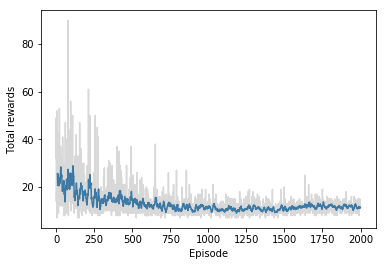

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

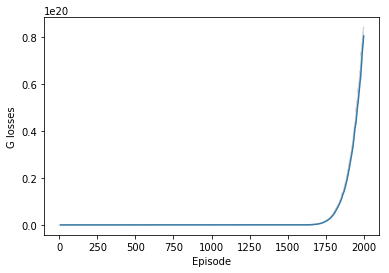

In [20]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

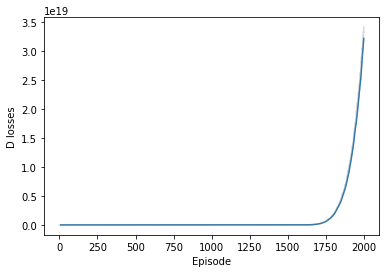

In [21]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.